Comp Stats TP4 Denis Duval

In [9]:
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import pandas as pd

#Exercice 1

#1.A

#Question 1

In [10]:
def mhP(x, target, sigma, component_to_modify, return_acc=False):
  xstar = np.zeros(x.shape[0])
  xstar[component_to_modify] = np.random.normal(0, sigma)
  xstar += x
  
  acc = min(1, target(xstar) / target(x))
  u = np.random.uniform()
  if u < acc:
    x = xstar

  if return_acc:
    return x, acc
  else:
    return x


In [11]:
def delta(j):
  if j == 0:
    return 0
  return min(0.01, j**(-0.5))


def mhwg_sampling(x0, target, sigma, max_iter=1000, return_rates=False, adaptive=False, update_freq=50):
  x = np.zeros((max_iter, x0.shape[0]))
  xk = x0

  rates = [[0] for i in range(x0.shape[0])]

  for i in range(max_iter):

    if i % update_freq == 0 and i > 0:
      j = i // update_freq
      for component_to_modify in range(x0.shape[0]):
        rates[component_to_modify][-1] /= update_freq
        if adaptive:
          sigma[component_to_modify] *= np.exp(delta(j) * np.sign(rates[component_to_modify][-1] - 0.24))
        rates[component_to_modify].append(0)
        
    for component_to_modify in range(x0.shape[0]):

      xk, acc = mhP(xk, target, sigma[component_to_modify], component_to_modify, return_acc=True)
      x[i, :] = xk
      rates[component_to_modify][-1] += acc


  # Remove the last element of each list in rates because it is not a rate
  for i in range(len(rates)):
    rates[i] = rates[i][:-1]
  
  if return_rates:
    return x, rates
  return x

#Question 2

In [12]:
sigma = [3, 3]
a = 10

In [13]:
def target(x):
  return np.exp(-x[0]**2/a**2 - x[1]**2 - 0.25*(x[0]**2/a**2 - x[1]**2)**2)

@np.vectorize
def target_vec(x, y):
  return target([x, y])

In [14]:
N = 10000
x, rates = mhwg_sampling(np.array([0,0]).astype(float), target, sigma, max_iter=N, return_rates=True)
x, y = x[:,0], x[:,1]

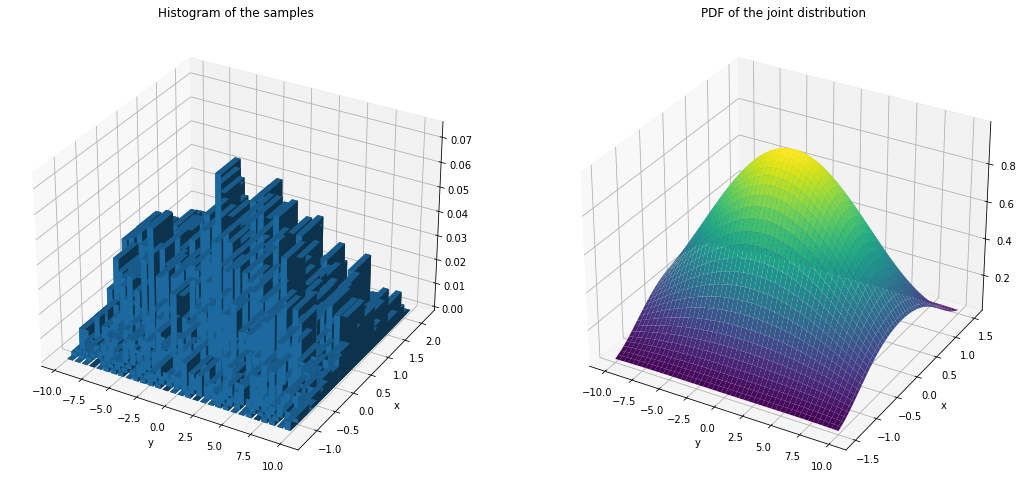

In [15]:
fig = plt.figure(figsize=(18, 9))
ax = fig.add_subplot(121, projection='3d')

#Plotting 2D Histogram of the samples
hist, xedges, yedges = np.histogram2d(x, y, bins=30, range=[[-10, 10], [-1.5, 1.5]], density=True)
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
ax.set_xlabel('y')
ax.set_ylabel('x')
ax.set_title('Histogram of the samples')

#Plotting the PDF of the joint distribution
X, Y = np.meshgrid(np.linspace(-10, 10, 100),np.linspace(-1.5, 1.5, 100))
Z = target_vec(X, Y)
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, Z, cmap='viridis')

ax2.set_xlabel('y')
ax2.set_ylabel('x')
ax2.set_title('PDF of the joint distribution')

plt.show()

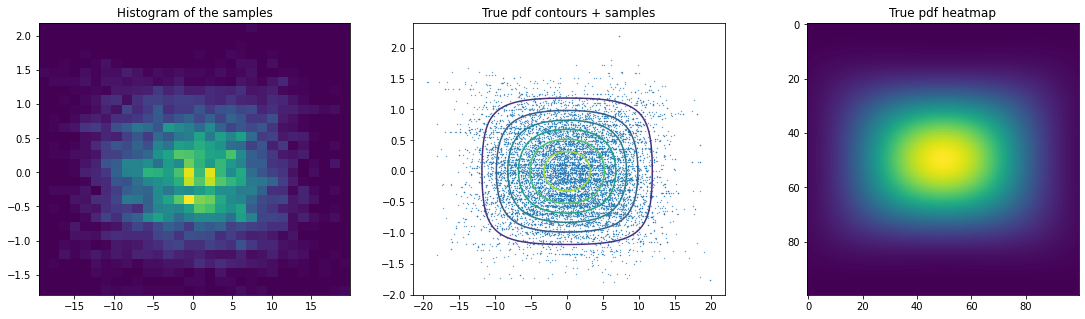

In [16]:
fig = plt.figure(figsize=(19, 5))

ax1 = fig.add_subplot(131)
ax1.hist2d(x, y, bins=30, density=True)
ax1.set_title('Histogram of the samples')

ax2 = fig.add_subplot(132)
X, Y = np.meshgrid(np.linspace(-15, 15, 100),np.linspace(-2, 2, 100))
Z = target_vec(X, Y)
ax2.contour(X, Y, Z, cmap='viridis')
ax2.scatter(x, y, s=0.1)
ax2.set_title('True pdf contours + samples')

ax3 = fig.add_subplot(133)
ax3.imshow(Z, cmap='viridis')
ax3.set_title('True pdf heatmap')
plt.show()

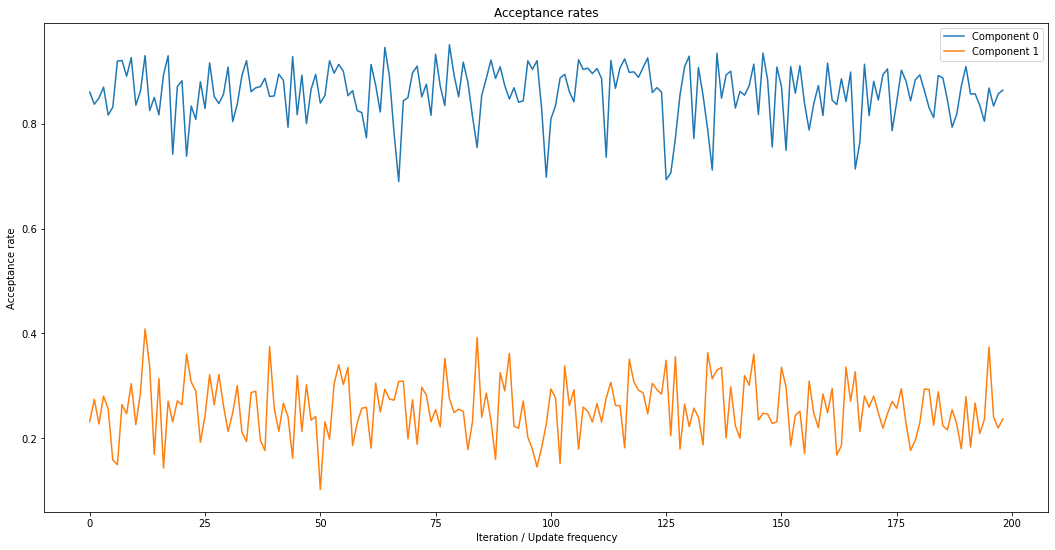

In [17]:
#plot the acceptance rates
fig = plt.figure(figsize=(18, 9))
ax = fig.add_subplot(111)
for i in range(len(rates)):
    ax.plot(rates[i], label='Component {}'.format(i))
ax.set_xlabel('Iteration / Update frequency')
ax.set_ylabel('Acceptance rate')
ax.set_title('Acceptance rates')
ax.legend()
plt.show()


De manière générale l'algorithme produit des courbes qui ressemblent à ce que l'on devrait obtenir théoriquement. Les courbes de ratios d'acceptance montrent que beaucoup d'échantillons sont acceptés selon l'axe $x$. Cela est non optimal car on sait que le taux optimal en dimension $1$ est d'environ $0.234$.

#Question 3

Cet algorithme utilise les mêmes variances de proposition pour les deux axes or la densité cible n'est pas forcément symétrique par rapport aux deux axes (ici elle ne l'est pas). On peut donc essayer de prendre des variances $\sigma_i$ qui soient adaptées aux deux axes. De plus on voit que les taux d'acceptations sur l'axe $x$ sont tres élevés (environ 0.9 en moyenne). Or on sait que le taux d'acceptation optimal (en dimension 1 au moins) est plus bas. Une première méthode pourrait donc être d'augmenter la variance selon un axe lorsque le taux d'acceptation est trop haut et la baisser lorsque le taux est trop bas.

#1.B

#Question 1

In [18]:
N = 10000
x, rates = mhwg_sampling(np.array([0,0]).astype(float), target, sigma, max_iter=N, return_rates=True, adaptive=True, update_freq=50)
x, y = x[:,0], x[:,1]

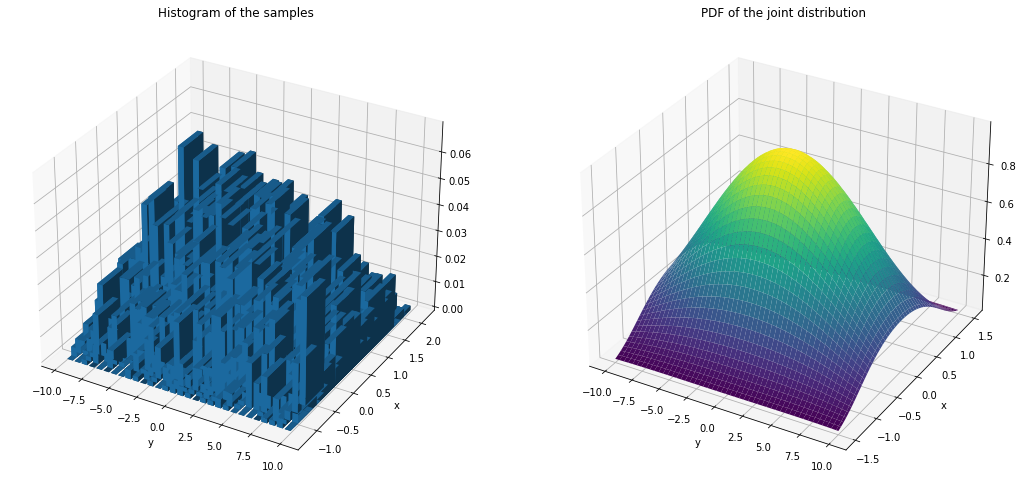

In [19]:
fig = plt.figure(figsize=(18, 9))
ax = fig.add_subplot(121, projection='3d')

#Plotting 2D Histogram of the samples
hist, xedges, yedges = np.histogram2d(x, y, bins=30, range=[[-10, 10], [-1.5, 1.5]], density=True)
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
ax.set_xlabel('y')
ax.set_ylabel('x')
ax.set_title('Histogram of the samples')

#Plotting the joint pdf
X, Y = np.meshgrid(np.linspace(-10, 10, 100),np.linspace(-1.5, 1.5, 100))
Z = target_vec(X, Y)
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, Z, cmap='viridis')

ax2.set_xlabel('y')
ax2.set_ylabel('x')
ax2.set_title('PDF of the joint distribution')

plt.show()


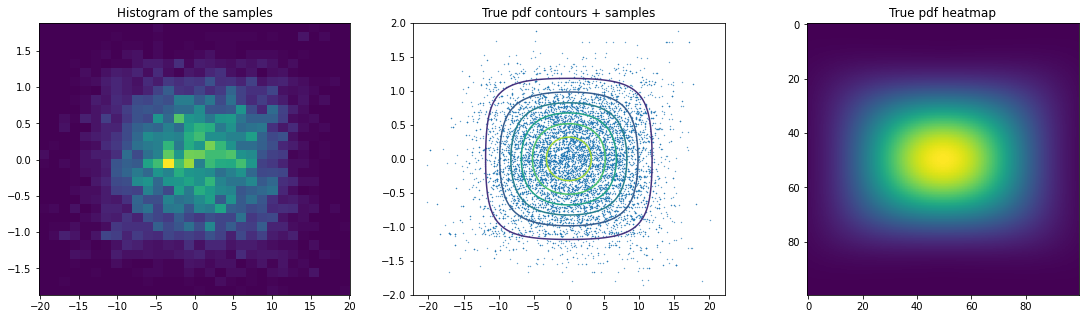

In [20]:
fig = plt.figure(figsize=(19, 5))

ax1 = fig.add_subplot(131)
ax1.hist2d(x, y, bins=30, density=True)
ax1.set_title('Histogram of the samples')

ax2 = fig.add_subplot(132)
X, Y = np.meshgrid(np.linspace(-15, 15, 100),np.linspace(-2, 2, 100))
Z = target_vec(X, Y)
ax2.contour(X, Y, Z, cmap='viridis')
ax2.scatter(x, y, s=0.1)
ax2.set_title('True pdf contours + samples')

ax3 = fig.add_subplot(133)
ax3.imshow(Z, cmap='viridis')
ax3.set_title('True pdf heatmap')
plt.show()

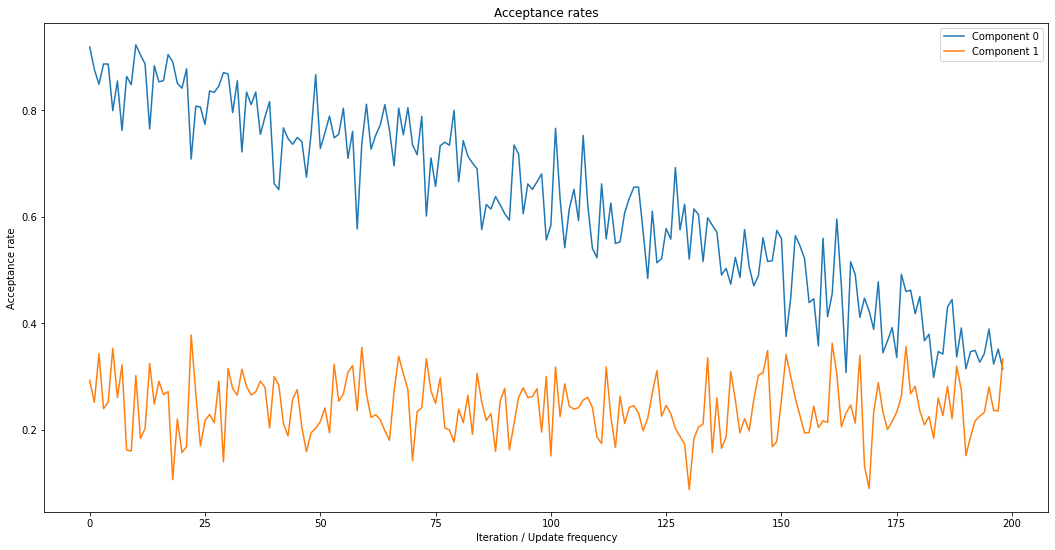

In [21]:
#plot the acceptance rates of the adaptive MH
fig = plt.figure(figsize=(18, 9))
ax = fig.add_subplot(111)
for i in range(len(rates)):
    ax.plot(rates[i], label='Component {}'.format(i))
ax.set_xlabel('Iteration / Update frequency')
ax.set_ylabel('Acceptance rate')
ax.set_title('Acceptance rates')
ax.legend()
plt.show()

In [22]:
def crosscorr(x,y,max_lag=None):
    if max_lag is None:
        max_lag=len(x)
    sx=pd.Series(x)
    sy=pd.Series(y)
    res=np.zeros(max_lag)
    for lag in range(1,max_lag):
        res[lag]=sx.corr(sy.shift(lag))
    res[0]=1
    return res

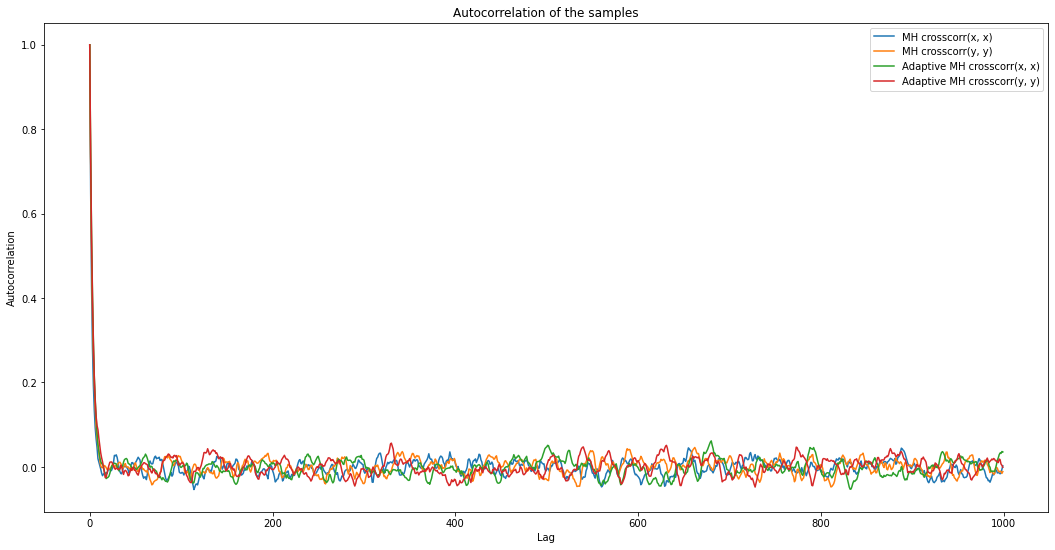

In [23]:
N = 10000
x, rates = mhwg_sampling(np.array([0,0]).astype(float), target, sigma, max_iter=N, return_rates=True)
x, y = x[:,0], x[:,1]

x_adaptative, rates = mhwg_sampling(np.array([0,0]).astype(float), target, sigma, max_iter=N, return_rates=True, adaptive=True, update_freq=50)
x_adaptative, y_adaptative = x_adaptative[:,0], x_adaptative[:,1]

#compare the autocorrelation of the samples of the two methods
fig = plt.figure(figsize=(18, 9))
ax = fig.add_subplot(111)
ax.plot(crosscorr(x, x, max_lag=1000), label='MH crosscorr(x, x)')
ax.plot(crosscorr(y, y, max_lag=1000), label='MH crosscorr(y, y)')
ax.plot(crosscorr(x_adaptative, x_adaptative, max_lag=1000), label='Adaptive MH crosscorr(x, x)')
ax.plot(crosscorr(y_adaptative, y_adaptative, max_lag=1000), label='Adaptive MH crosscorr(y, y)')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.set_title('Autocorrelation of the samples')
ax.legend()
plt.show()

L'algorithme MHwG adaptatif a mieux réussi a échantillonner selon cette densité. En effet on voit sur la figure avec les contours et les échantillons que les échantillons sont plus homogènes selon les axes ce qui montre que l'algorithme a bien pris en compte le caractère non symétrique de la densité. Cela se voit sur la courbe des ratios d'acceptance pour $y$ puisque la variance a été augmentée jusqu'à ce que le ratio d'acceptance converge vers la valeur optimale. Cependant, on ne réussit pas à observer ici une différence sur les graphes d'autocorrélation des chaines.

#Question 2

In [24]:
B = 0.1
d = 20
sigma = np.ones(d)
def banana_density(x):
    return np.exp(-x[0]**2/200 -0.5*(x[1]+B*x[0]**2-100*B)**2 - 0.5*np.sum(x[2:]**2))

In [25]:
#testing with the banana distribution
N = 100000
x, rates = mhwg_sampling(np.zeros(d), banana_density, sigma, max_iter=N, return_rates=True)
x, y = x[:,0], x[:,1]

x_adaptative, rates = mhwg_sampling(np.zeros(d), banana_density, sigma, max_iter=N, return_rates=True, adaptive=True, update_freq=50)
x_adaptative, y_adaptative = x_adaptative[:,0], x_adaptative[:,1]

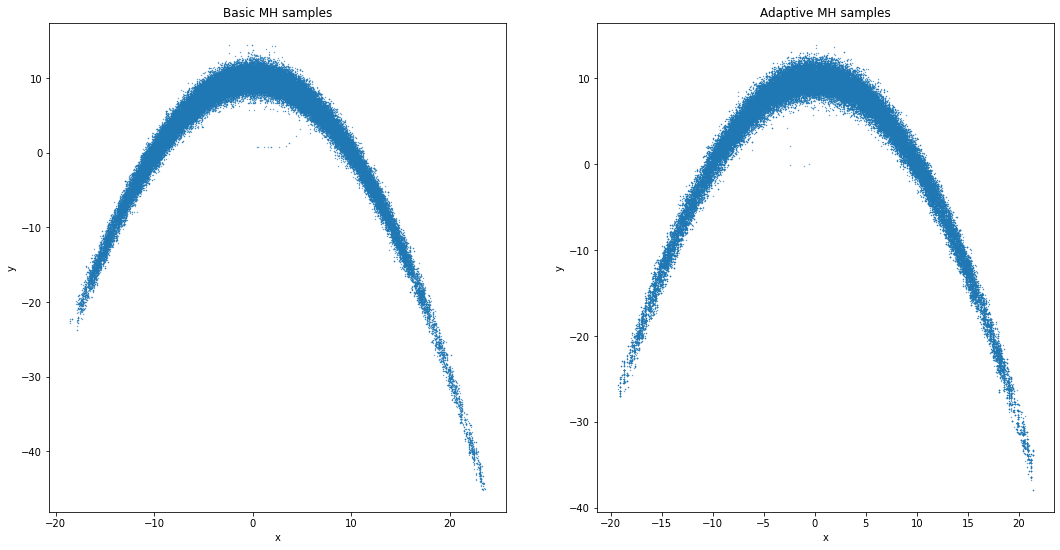

In [26]:
#scatter plot of the samples
fig = plt.figure(figsize=(18, 9))
ax = fig.add_subplot(121)
ax.scatter(x, y, s=0.1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Basic MH samples')

ax2 = fig.add_subplot(122)
ax2.scatter(x_adaptative, y_adaptative, s=0.1)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Adaptive MH samples')
plt.show()

In [27]:
cov = np.loadtxt('tmalaexcov.txt')
d = 20
sigma = np.ones(d)
def gaussian_density(x):
    return sp.multivariate_normal.pdf(x, mean=np.zeros(d), cov=cov)
@np.vectorize
def gaussian_density_vec(x, y):
    return sp.multivariate_normal.pdf([x, y], mean=np.zeros(2), cov=cov[:2,:2])

In [28]:
#testing with the gaussian distribution
N = 1000
x, rates = mhwg_sampling(np.zeros(d), gaussian_density, sigma, max_iter=N, return_rates=True)
x, y = x[:,0], x[:,1]

x_adaptative, rates = mhwg_sampling(np.zeros(d), gaussian_density, sigma, max_iter=N, return_rates=True, adaptive=True, update_freq=50)
x_adaptative, y_adaptative = x_adaptative[:,0], x_adaptative[:,1]

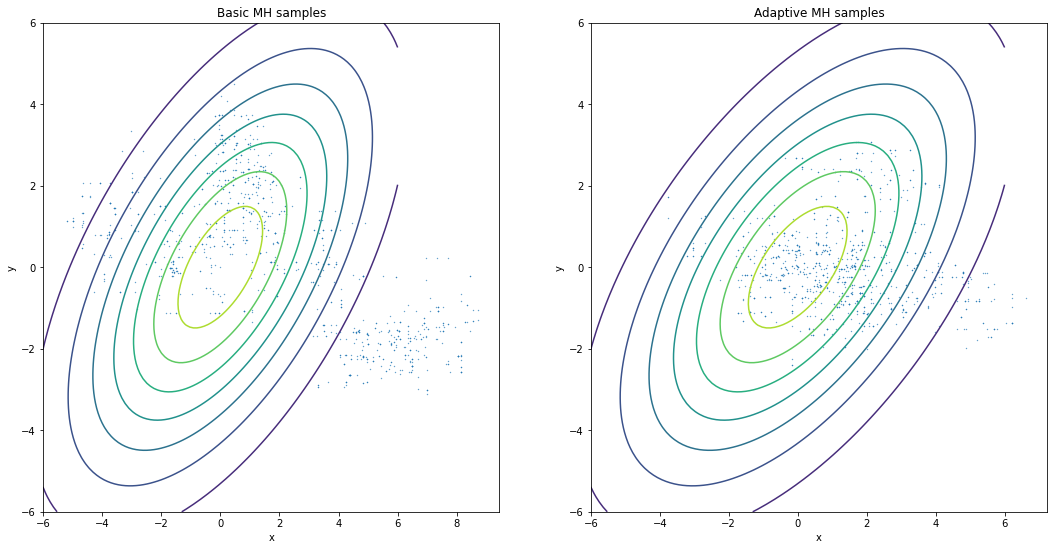

In [29]:
#scatter plot of the samples
fig = plt.figure(figsize=(18, 9))
ax = fig.add_subplot(121)
ax.scatter(x, y, s=0.1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Basic MH samples')
#plot the contours of the target distribution
X, Y = np.meshgrid(np.linspace(-6, 6, 100), np.linspace(-6, 6, 100))
Z = gaussian_density_vec(X, Y)
ax.contour(X, Y, Z, cmap='viridis')

ax2 = fig.add_subplot(122)
ax2.scatter(x_adaptative, y_adaptative, s=0.1)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Adaptive MH samples')
#plot the contours of the target distribution
ax2.contour(X, Y, Z, cmap='viridis')
plt.show()

Pour ces deux densités on ne voit pas de différence majeure entre les deux algorithmes. Pour la densité gaussienne l'algorithme adaptatif semble légérement meilleur mais on observe dans les cas le fléau de la grande dimension.

#Exercice 2

#2-A

In [30]:
mu = [[2.18,5.76],[8.67,9.59],[4.24,8.48],[8.41,1.68],[3.93,8.82],[3.25,3.47],[1.70,0.50],[4.59,5.60],[6.91,5.81],[6.87,5.40],[5.41,2.65],[2.70,7.88],[4.98,3.70],[1.14,2.39],[8.33,9.50],[4.93,1.50],[1.83,0.09],[2.26,0.31],[5.54,6.86],[1.69,8.11]]
omega = 0.05
sigma = 0.1

In [31]:
def target_mixture(x):
    return np.sum([omega*sp.multivariate_normal.pdf(x, mean=mu[i], cov=sigma**2*np.eye(2)) for i in range(20)])

@np.vectorize
def target_mixture_vec(x, y):
    return target_mixture([x, y])

#Question 1

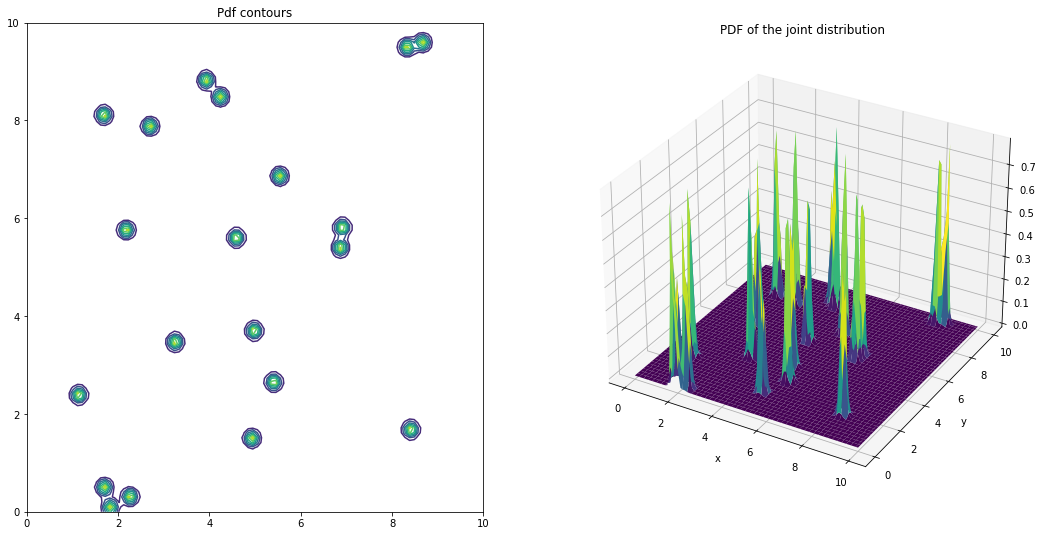

In [32]:
fig = plt.figure(figsize=(18, 9))
ax1 = fig.add_subplot(121)

#Plotting the contours of the target distribution
X, Y = np.meshgrid(np.linspace(0, 10, 100),np.linspace(0, 10, 100))
Z = target_mixture_vec(X, Y)
ax1.contour(X, Y, Z, cmap='viridis')
ax1.set_title('Pdf contours')

#Plotting the PDF of the target distribution
X, Y = np.meshgrid(np.linspace(0, 10, 100),np.linspace(0, 10, 100))
Z = target_mixture_vec(X, Y)
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, Z, cmap='viridis')

ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('PDF of the joint distribution')

plt.show()

In [33]:
#define a metropolis hastings sampler
def mh(x0, target, cov, max_iter=1000, return_rates=False, update_freq=50):
    xk = x0
    x = np.zeros((max_iter, x0.shape[0]))
    rates = [0]

    for k in range(max_iter):
        #Computing the mean rate
        if k%update_freq == 0 and k > 0:
            rates[-1] /= update_freq
            rates.append(0)
        
        #Proposal 
        xstar = xk + np.random.multivariate_normal(np.zeros(x0.shape[0]), cov)

        #Acceptance-rejection
        alpha = min(1, target(xstar)/target(xk))
        u = np.random.uniform()
        if u < alpha:
            xk = xstar
        x[k] = xk
        rates[-1] += alpha
    #remove the last element of rates
    rates = rates[:-1]
    if return_rates:
        return x, rates
    return x

#Question 2

In [34]:
cov_proposal = np.eye(2)
x, rates = mh(np.array([0, 0]), target_mixture, cov_proposal, max_iter=1000, return_rates=True, update_freq=50)
x, y = x[:,0], x[:,1]

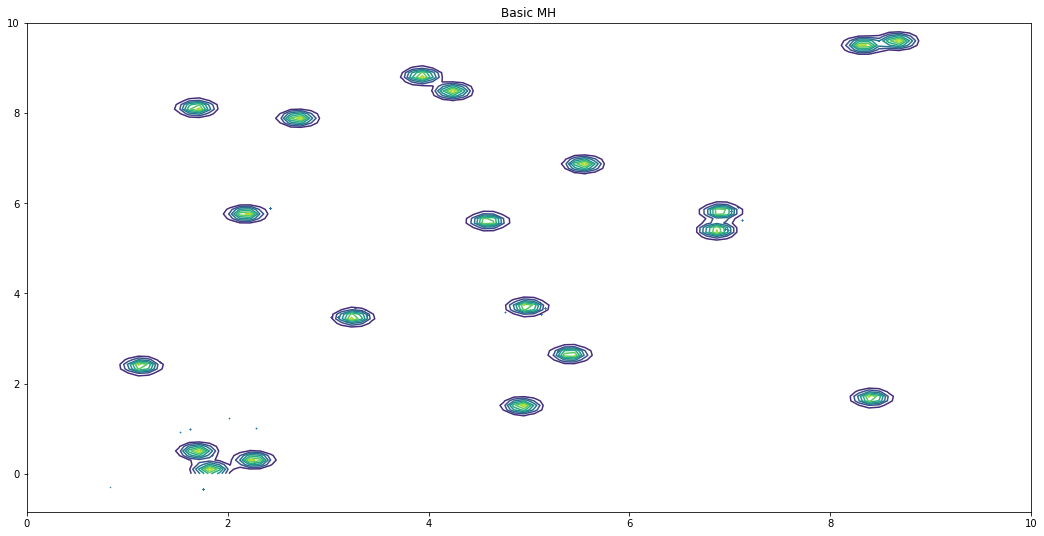

In [35]:
fig = plt.figure(figsize=(18, 9))
ax1 = fig.add_subplot(111)

#Plotting the contours of the target distribution
X, Y = np.meshgrid(np.linspace(0, 10, 100),np.linspace(0, 10, 100))
Z = target_mixture_vec(X, Y)
ax1.contour(X, Y, Z, cmap='viridis')
ax1.set_title('Basic MH')
ax1.scatter(x, y, s=0.1)

plt.show()

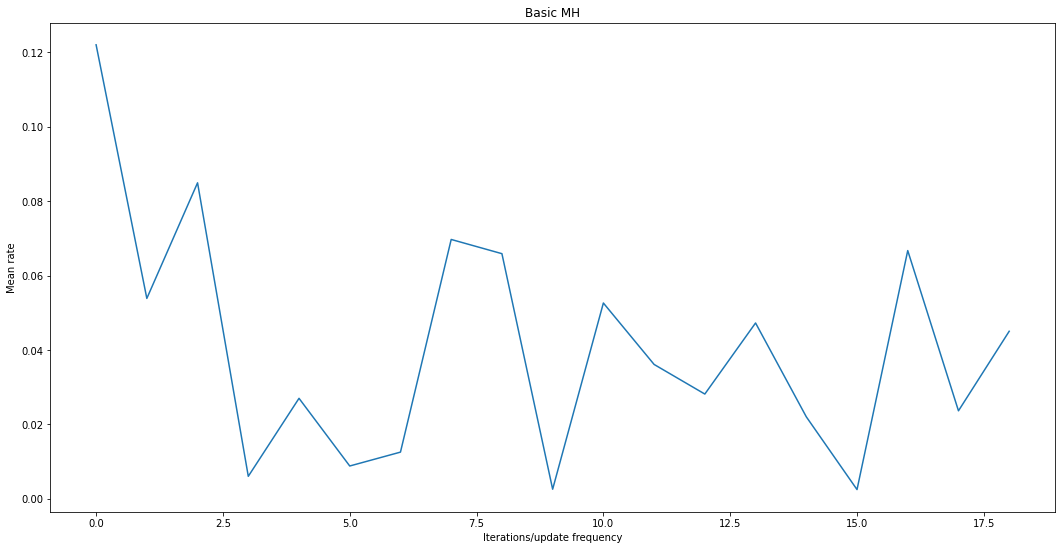

In [36]:
#plot the rates
fig = plt.figure(figsize=(18, 9))
ax1 = fig.add_subplot(111)
ax1.plot(rates)
ax1.set_xlabel('Iterations/update frequency')
ax1.set_ylabel('Mean rate')
ax1.set_title('Basic MH')

plt.show()

On voit que l'algorithme de Metropolis-Hastings a du mal a échantillonner selon une distribution qui est multimodale. En effet ici la chaine produite est de longueur 1000 et on voit beaucoup moins que 1000 échantillons sur le graphe de la densité. Seulement deux modes ont été découverts et ils ont été pauvrement échantillonnés. Cela se voit sur la courbe des ratios d'acceptance qui sont relativement bas par rapport au ratio optimal.
C'est dû au fait que le MH est quasiment incapable de se déplacer entre deux modes puisqu'ils sont séparés par des zones de densité très faibles et donc la probabilité que l'algorithme se déplace dans ces zones est quasi-nulle.

#2-B

#Question 1

In [37]:
T = np.array([60, 21.6, 7.7, 2.8, 1.0])

In [38]:
def parallel_tempering(x0, target, T, max_iter=1000, return_rates=False, update_freq=50):
    K = T.shape[0]
    x = np.zeros((max_iter, T.shape[0], x0.shape[0]))
    xk = np.zeros((T.shape[0], x0.shape[0]))
    xk[:, :] = x0

    indexes = [(i, j) for i in range(K) for j in range(K) if abs(i-j) == 1]
    for k in range(max_iter):
        for i in range(K):
            #Proposal 
            tau = 0.25 * np.sqrt(T[i])
            xstar = xk[i] + np.random.multivariate_normal(np.zeros(x0.shape[0]), tau**2 * np.eye(x0.shape[0]))

            #Acceptance-rejection
            alpha = min(1, (target(xstar)/target(xk[i]))**(1/T[i]))
            u = np.random.uniform()
            if u < alpha:
                xk[i] = xstar
        
        #Swapping
        i, j = indexes[np.random.randint(len(indexes))]
        alpha = min(1, (target(xk[i])/target(xk[j]))**(1/T[i] - 1/T[j]))
        u = np.random.uniform()
        if u < alpha:
            xk[[i, j]] = xk[[j, i]]
        x[k] = xk
    return x

#Question 2

In [39]:
x = parallel_tempering(np.array([0, 0]), target_mixture, T, max_iter=10000)
x, y = x[:, 4, 0], x[:, 4, 1]

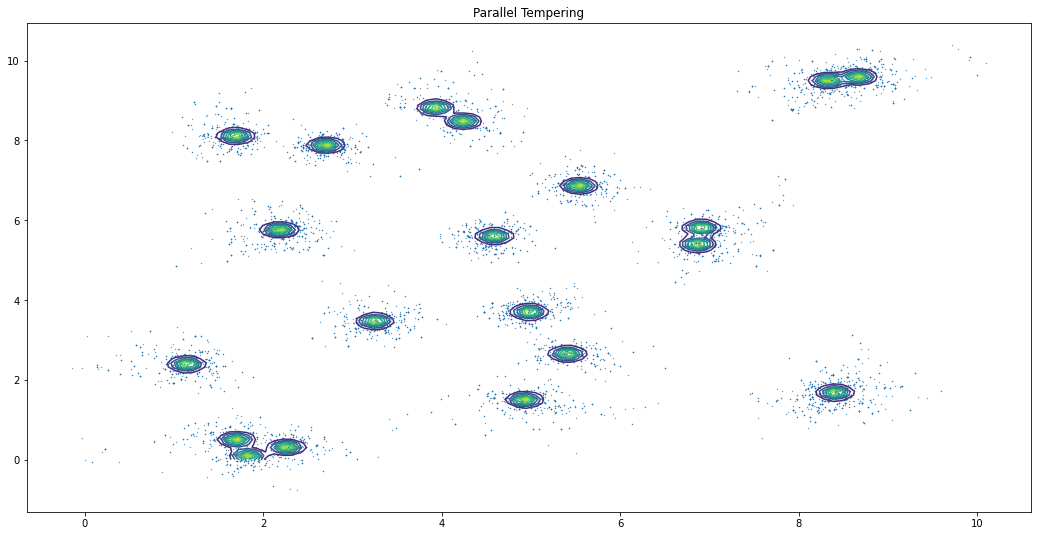

In [40]:
#plot the samples of the last chain
fig = plt.figure(figsize=(18, 9))
ax1 = fig.add_subplot(111)

#Plotting the contours of the target distribution
X, Y = np.meshgrid(np.linspace(0, 10, 100),np.linspace(0, 10, 100))
Z = target_mixture_vec(X, Y)
ax1.contour(X, Y, Z, cmap='viridis')
ax1.set_title('Parallel Tempering')
ax1.scatter(x, y, s=0.1)

plt.show()

On voit que l'algorithme de parallel tempering est beaucoup plus adapté pour ce genre de distributions. En effet le fait de faire des chaines avec différentes températures permet de découvrir d'autres modes (pour la densité cible) en créant des chemins entre les modes grâces aux températures hautes. Ici l'algorithme donne des résultats assez satisfaisants. Tous les modes ont été découverts et relativement bien échantillonnés.

#Exercice 3

#Question 1

On veut écrire a constante près $q(X, \mu, \sigma^2, \tau^2|Y)$.
En utilisant la règle de Bayes:
$$q(X, \mu, \sigma^2, \tau^2|Y) \propto q(Y|X, \mu, \sigma^2, \tau^2) \cdot q(X| \mu, \sigma^2, \tau^2) \cdot \pi_{prior}(\mu, \sigma^2, \tau^2)$$

Les trois termes s'écrivent :
$$q(Y|X, \mu, \sigma^2, \tau^2) = \prod_{i=1}^N \prod_{j=1}^{k_i}\mathcal{N}(X_i - y_{ij}|0, \tau^2)$$
$$q(X|\mu, \sigma^2, \tau^2) = \prod_{i=1}^N \mathcal{N}(X_i|\mu, \sigma^2)$$
$$\pi_{prior}(\mu, \sigma^2, \tau^2) \propto \frac{1}{\sigma^{2(1+\alpha)}}\exp(-\frac{\beta}{\sigma^2})\frac{1}{\tau^{2(1+\gamma)}}\exp(-\frac{\beta}{\tau^2})$$
D'où:
$$q(X, \mu, \sigma^2, \tau^2|Y) \propto \sigma^{-2(1+\alpha)-N}\tau^{-2(1+\gamma)-k}\exp(-\frac{\beta}{\sigma^2}-\frac{\beta}{\tau^2}-\frac{1}{2\tau^2}\sum_i\sum_j(X_i-y_{ij})^2 -\frac{1}{2\sigma^2}\sum_i(X_i-\mu)^2)$$

#Question 2

Du calcul de la loi a posteriori, on en déduit les conditionnelles :
$$q(\sigma^2|X, \mu, \tau^2) \propto \frac{1}{\sigma^{2(1+\alpha+N/2)}}\exp(-\frac{\beta + 0.5\sum_i (X_i-\mu)^2}{\sigma^2})$$
On reconnait une loi $\Gamma^{-1}(\alpha+N/2, \beta + 0.5\sum_i (X_i-\mu)^2)$
De même on a $$q(\tau^2|X, \mu, \sigma^2) \sim \Gamma^{-1}(\gamma+k/2, \beta + 0.5\sum_i \sum_j(X_i-y_{ij})^2)$$.
On a $q(\mu|X, \sigma^2, \tau^2) \propto \exp(-\frac{1}{2\sigma^2}\sum_i (X_i-\mu)^2)$. En développant $\sum_i (X_i-\mu)^2 = N(\mu^2 - 2\mu(\sum_i X_i)/N + \sum_i X_i^2) = N(\mu-(\sum_i X_i)/N)^2 + C$ avec une C une constante qui ne dépend pas de $\mu$ on peut réarranger les termes et on a :
$$q(\mu|X, \sigma^2, \tau^2) \sim \mathcal{N}(\frac{\sum_i X_i}{N}, \frac{\sigma^2}{N})$$
Finalement on a $q(X_i|\mu, \sigma^2, \tau^2) \propto \exp(-\frac{1}{2\tau^2}\sum_j (y_{ij}-X_i)^2-\frac{(X_i-\mu)^2}{2\sigma^2})$
De même en développant les carrés dans l'exponentielle on peut déterminer les paramètres de la gaussienne. On obtient :
$$q(X_i|\mu, \sigma^2, \tau^2) \sim \mathcal{N}(\frac{\tau^2\mu+\sigma^2\sum_j y_{ij}}{k_i\sigma^2+\tau^2}, \frac{\sigma^2\tau^2}{k_i \sigma^2 + \tau^2})$$

In [41]:
N = 100
k = 30

alpha = 1
gamma = 1
beta = 1

In [42]:
def gibbs_sampler(X, mu, sigma, tau, y, max_iter=1000):
    Xs = np.zeros((max_iter, N))
    mus = np.zeros(max_iter)
    sigmas = np.zeros(max_iter)
    taus = np.zeros(max_iter)

    Xk = X.copy()
    muk = mu
    sigmak = sigma
    tauk = tau

    for i in range(max_iter):
        
        #sample sigma2
        sigmak = 1/np.random.gamma(alpha + N/2, 1/(beta + 0.5*np.sum((Xk - muk)**2)))

        #sample tau2
        tauk = 1/np.random.gamma(gamma + N*k/2, 1/(beta + 0.5*np.sum((Xk - y.T)**2)))

        #sample mu
        muk = np.random.normal(loc=Xk.mean(), scale=np.sqrt(sigmak/N))

        #sample X
        for j in range(N):
            Xk[j] = np.random.normal(loc=(tauk*muk+ sigmak*y[j].sum())/(tauk + k*sigmak), scale=np.sqrt(sigmak*tauk/(tauk + k*sigmak)))

        sigmas[i] = sigmak
        taus[i] = tauk
        mus[i] = muk
        Xs[i] = Xk
    
    return Xs, mus, sigmas, taus

#Question 3

Il faut trouver la loi du couple $(X, \mu)$ conditionnellement aux autres paramètres. D'après le calcul de la loi a posteriori on a :
$$q(X, \mu|\sigma^2, \tau^2, y) \propto \exp(-\frac{1}{2\tau^2}\sum_i\sum_j(y_{ij}-X_i)^2-\frac{1}{2\sigma^2}\sum_i(\mu-X_i)^2)$$
En développant les carrés dans l'exponentielle:
$$q(X, \mu|\sigma^2, \tau^2, y) \propto \exp(-\frac{1}{2}(\sum_i X_i^2\frac{k_i \sigma^2 + \tau^2}{\sigma^2\tau^2} - 2X_i\sum_j y_{ij}/\tau^2 - 2X_i\mu/\sigma^2 + \mu^2/\sigma^2) )$$
On reconnait une gaussienne multivariée de dimension $n+1$. De plus on reconnait les coefficients de la matrice de covariance (de son inverse). En effet si $A$ est une matrice alors $X^TAX = \sum_i\sum_j A_{ij}X_iX_j$ et de plus si elle est symétrique on peut identifier les coefficients. On a :

$$\Sigma^{-1}_{ii} = \frac{k_i \sigma^2 + \tau^2}{\sigma^2\tau^2}$$
si $1 \leq i \leq n$. 
$$\Sigma^{-1}_{n+1, n+1} = \frac{N}{\sigma^2}$$
$$\Sigma^{-1}_{j, n+1} = -\frac{1}{\sigma^2}$$
si $1\leq j \leq n+1$ et $0$ ailleurs.
On peut remonter à la moyenne $m$:

$$\Sigma^{-1}m = [\frac{\sum_j y_{1j}}{\tau^2}, ... ,\frac{\sum_j y_{Nj}}{\tau^2}, 0]$$
$$m = \Sigma[\frac{\sum_j y_{1j}}{\tau^2}, ... ,\frac{\sum_j y_{Nj}}{\tau^2}, 0]$$

On a donc $$q(X, \mu|\sigma^2, \tau^2, y) \sim \mathcal{N}(m, \Sigma)$$.


In [43]:
def mean_cov(sigma, tau, y):
    cov = np.zeros((N+1, N+1))
    cov [N, N] = N/sigma
    for j in range(N):
        cov[N, j] = -1/sigma
        cov[j, N] = -1/sigma
    for i in range(N):
        cov[i, i] = (tau + k*sigma)/(sigma*tau)
    cov = np.linalg.inv(cov)

    mean = np.zeros(N+1)
    for i in range(N):
        mean[i] = y[i].sum()/tau

    mean = cov @ mean

    return mean, cov

In [44]:
def block_gibbs_sampler(X, mu, sigma, tau, y, max_iter=1000):
    Xs = np.zeros((max_iter, N))
    mus = np.zeros(max_iter)
    sigmas = np.zeros(max_iter)
    taus = np.zeros(max_iter)

    Xk = X.copy()
    muk = mu
    sigmak = sigma
    tauk = tau

    for i in range(max_iter):
        
        #sample sigma2
        sigmak = 1/np.random.gamma(alpha + N/2, 1/(beta + 0.5*np.sum((Xk - muk)**2)))

        #sample tau2
        tauk = 1/np.random.gamma(gamma + N*k/2, 1/(beta + 0.5*np.sum((Xk - y.T)**2)))

        #sample (X, mu)
        mean, cov = mean_cov(sigmak, tauk, y)
        v = np.random.multivariate_normal(mean=mean, cov=cov)

        muk = v[N]
        Xk = v[:N]

        sigmas[i] = sigmak
        taus[i] = tauk
        mus[i] = muk
        Xs[i] = Xk
    
    return Xs, mus, sigmas, taus

#Question 5

In [45]:
real_mu = 5
real_sigma = 0.1
real_tau = 0.1

real_X = np.random.normal(loc=real_mu, scale=np.sqrt(real_sigma), size=N)
y = np.zeros((N, k))
for i in range(N):
    y[i] = np.random.normal(loc=real_X[i], scale=np.sqrt(real_tau), size=k)

In [46]:
Xs, mus, sigmas, taus = gibbs_sampler(X=np.zeros(N), mu=0, sigma=1, tau=1, y=y, max_iter=1000)
Xs_block, mus_block, sigmas_block, taus_block = block_gibbs_sampler(X=np.zeros(N), mu=0, sigma=1, tau=1, y=y, max_iter=1000)

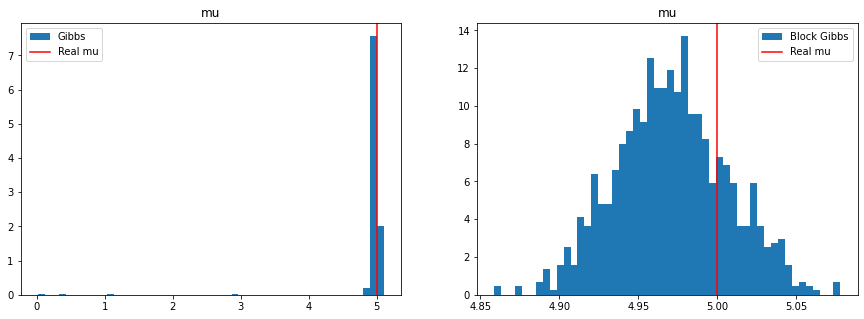

In [47]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.hist(mus, bins=50, density=True, label='Gibbs')
ax1.axvline(real_mu, color='red', label='Real mu')
ax1.set_title('mu')
ax1.legend()

ax2.hist(mus_block, bins=50, density=True, label='Block Gibbs')
ax2.axvline(real_mu, color='red', label='Real mu')
ax2.set_title('mu')
ax2.legend()

plt.show()


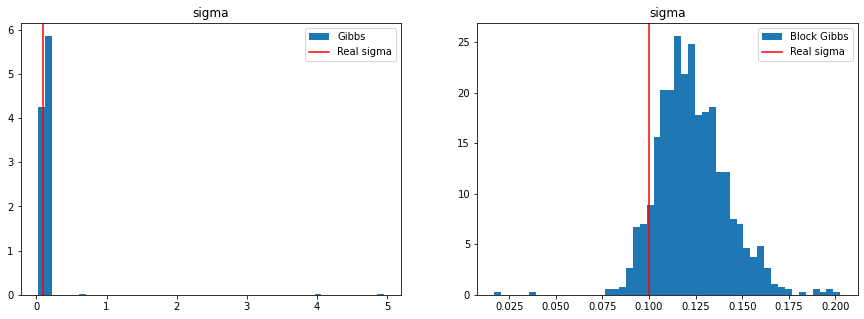

In [48]:
#do the same for sigma
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.hist(sigmas, bins=50, density=True, label='Gibbs')
ax1.axvline(real_sigma, color='red', label='Real sigma')
ax1.set_title('sigma')
ax1.legend()

ax2.hist(sigmas_block, bins=50, density=True, label='Block Gibbs')
ax2.axvline(real_sigma, color='red', label='Real sigma')
ax2.set_title('sigma')
ax2.legend()

plt.show()

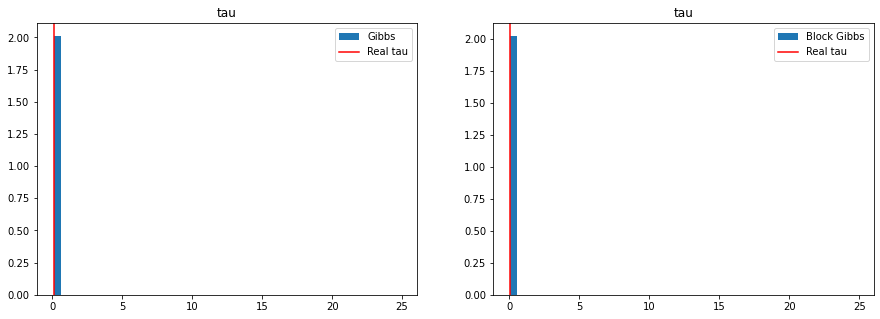

In [49]:
#do the same for tau
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.hist(taus, bins=50, density=True, label='Gibbs')
ax1.axvline(real_tau, color='red', label='Real tau')
ax1.set_title('tau')
ax1.legend()

ax2.hist(taus_block, bins=50, density=True, label='Block Gibbs')
ax2.axvline(real_tau, color='red', label='Real tau')
ax2.set_title('tau')
ax2.legend()

plt.show()